# Comparison with Seapodym-LMTL Zooplankton


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import Markdown

from seapopym.configuration.no_transport.configuration import NoTransportConfiguration
from seapopym.configuration.no_transport.parameter import ForcingParameters, FunctionalGroups, NoTransportParameters
from seapopym.configuration.parameters.parameter_environment import (
    ChunkParameter,
    ClientParameter,
    EnvironmentParameter,
    OutputParameter,
    PreProductionParameter,
)
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.configuration.parameters.parameter_functional_group import (
    FunctionalGroupUnit,
    FunctionalGroupUnitMigratoryParameters,
    FunctionalGroupUnitRelationParameters,
)
from seapopym.logging.custom_logger import set_debug, set_error
from seapopym.model.no_transport_model import NoTransportModel
from seapopym.standard.units import StandardUnitsLabels

# set_debug()
# set_error()

In [2]:
path_forcing = (
    "/Users/ash/Documents/Workspaces/Data/phd/cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-i_1709010880580.nc"
)
path_bio = "/Users/ash/Documents/Workspaces/Data/phd/cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i_1709007157635.nc"

forcing = xr.open_dataset(path_forcing)
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
display(Markdown("### Physics"))
display(forcing)
bio = xr.open_dataset(path_bio)
display(Markdown("### Biology"))
display(bio)

### Physics

<xarray.Dataset> Size: 131MB
Dimensions:              (time: 4748, depth: 3, latitude: 24, longitude: 24)
Coordinates:
  * depth                (depth) float32 12B 1.0 2.0 3.0
  * latitude             (latitude) float32 96B 22.08 22.17 22.25 ... 23.92 24.0
  * longitude            (longitude) float32 96B -159.0 -158.9 ... -157.2 -157.1
  * time                 (time) datetime64[ns] 38kB 2010-01-01 ... 2022-12-31
Data variables:
    T                    (time, depth, latitude, longitude) float32 33MB ...
    U                    (time, depth, latitude, longitude) float32 33MB ...
    V                    (time, depth, latitude, longitude) float32 33MB ...
    pelagic_layer_depth  (time, depth, latitude, longitude) float32 33MB ...
Attributes:
    Conventions:       CF-1.11
    title:             Physical forcings of global ocean low and mid trophic ...
    institution:       CLS
    source:            SEAPODYM-LMTL 3.0.0
    history:           Created on 2022-09-28
    references:        http://www.cls.fr; http://www.seapodym.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_MULTIYEAR_BGC_001_033
    subset:datasetId:  cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-i_202211
    subset:date:       2024-02-27T05:14:40.588Z

### Biology

<xarray.Dataset> Size: 98MB
Dimensions:       (latitude: 24, longitude: 24, time: 4748)
Coordinates:
  * latitude      (latitude) float32 96B 22.08 22.17 22.25 ... 23.83 23.92 24.0
  * longitude     (longitude) float32 96B -159.0 -158.9 -158.8 ... -157.2 -157.1
  * time          (time) datetime64[ns] 38kB 2010-01-01 ... 2022-12-31
Data variables:
    mnkc_epi      (time, latitude, longitude) float32 11MB ...
    mnkc_hmlmeso  (time, latitude, longitude) float32 11MB ...
    mnkc_lmeso    (time, latitude, longitude) float32 11MB ...
    mnkc_mlmeso   (time, latitude, longitude) float32 11MB ...
    mnkc_mumeso   (time, latitude, longitude) float32 11MB ...
    mnkc_umeso    (time, latitude, longitude) float32 11MB ...
    npp           (time, latitude, longitude) float32 11MB ...
    zeu           (time, latitude, longitude) float32 11MB ...
    zooc          (time, latitude, longitude) float32 11MB ...
Attributes:
    Conventions:       CF-1.11
    title:             Global ocean low and mid trophic levels biomass conten...
    institution:       CLS
    source:            SEAPODYM-LMTL 3.0.0
    history:           Created on 2022-09-28
    references:        http://www.cls.fr; http://www.seapodym.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_MULTIYEAR_BGC_001_033
    subset:datasetId:  cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i_202211
    subset:date:       2024-02-27T04:12:37.642Z

## Initialize the model


In [3]:
tr_max = 527
tr_rate = -0.125
inv_lambda_max = 2109
inv_lambda_rate = 0.125
global_energy_coef = 0.0042
functional_type = FunctionalGroupUnitRelationParameters(
    inv_lambda_max=inv_lambda_max,
    inv_lambda_rate=inv_lambda_rate,
    temperature_recruitment_rate=tr_rate,
    cohorts_timesteps=[1] * np.ceil(tr_max).astype(int),
    temperature_recruitment_max=tr_max,
)

epipelagic = FunctionalGroupUnit(
    name="epipelagic",
    migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=1, night_layer=1),
    functional_type=functional_type,
    energy_transfert=global_energy_coef * 0.17,
)
upper_mesopelagic = FunctionalGroupUnit(
    name="upper_mesopelagic",
    migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=2, night_layer=2),
    functional_type=functional_type,
    energy_transfert=global_energy_coef * 0.22,
)
migrant_upper_mesopelagic = FunctionalGroupUnit(
    name="migrant_upper_mesopelagic",
    migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=2, night_layer=1),
    functional_type=functional_type,
    energy_transfert=global_energy_coef * 0.10,
)
lower_mesopelagic = FunctionalGroupUnit(
    name="lower_mesopelagic",
    migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=3, night_layer=3),
    functional_type=functional_type,
    energy_transfert=global_energy_coef * 0.20,
)
migrant_lower_mesopelagic = FunctionalGroupUnit(
    name="migrant_lower_mesopelagic",
    migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=3, night_layer=2),
    functional_type=functional_type,
    energy_transfert=global_energy_coef * 0.13,
)
highly_migrant_lower_mesopelagic = FunctionalGroupUnit(
    name="highly_migrant_lower_mesopelagic",
    migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=3, night_layer=1),
    functional_type=functional_type,
    energy_transfert=global_energy_coef * 0.18,
)

f_groups = FunctionalGroups(
    functional_groups=[
        epipelagic,
        upper_mesopelagic,
        migrant_upper_mesopelagic,
        lower_mesopelagic,
        migrant_lower_mesopelagic,
        highly_migrant_lower_mesopelagic,
    ]
)
p_param = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=0.08333),
    primary_production=ForcingUnit(forcing=bio["npp"], resolution=0.08333),
)
parameters = NoTransportParameters(
    functional_groups_parameters=f_groups,
    forcing_parameters=p_param,
    environment_parameters=EnvironmentParameter(chunk=ChunkParameter(functional_group=1)),
)
micronekton_model = NoTransportModel(configuration=NoTransportConfiguration(parameters))

2024-04-09 16:22:56,502 :: Seapodym ::  WARNING ::
|	npp unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



Let's see how much memory is taking the model in the current state.


In [4]:
micronekton_model.expected_memory_usage

'The expected memory usage is 138952.37 MB.'

That's really much and even if we cut the data in small pieces using `chunks = {functional_group:1, latitude:1, longitude:1}` we have a lot of I/O operations and the model is still taking a lot of memory.


---

## Try again with sub-cohorts definition


In [5]:
head = [30] * np.floor(tr_max / 30).astype(int)
tail = [np.ceil(tr_max - sum(head))]
cohorts_timesteps = head + tail
functional_type = FunctionalGroupUnitRelationParameters(
    inv_lambda_max=inv_lambda_max,
    inv_lambda_rate=inv_lambda_rate,
    temperature_recruitment_rate=tr_rate,
    cohorts_timesteps=cohorts_timesteps,
    temperature_recruitment_max=tr_max,
)

epipelagic = FunctionalGroupUnit(
    name="epipelagic",
    migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=1, night_layer=1),
    functional_type=functional_type,
    energy_transfert=global_energy_coef * 0.17,
)
upper_mesopelagic = FunctionalGroupUnit(
    name="upper_mesopelagic",
    migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=2, night_layer=2),
    functional_type=functional_type,
    energy_transfert=global_energy_coef * 0.10,
)
migrant_upper_mesopelagic = FunctionalGroupUnit(
    name="migrant_upper_mesopelagic",
    migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=2, night_layer=1),
    functional_type=functional_type,
    energy_transfert=global_energy_coef * 0.22,
)
lower_mesopelagic = FunctionalGroupUnit(
    name="lower_mesopelagic",
    migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=3, night_layer=3),
    functional_type=functional_type,
    energy_transfert=global_energy_coef * 0.18,
)
migrant_lower_mesopelagic = FunctionalGroupUnit(
    name="migrant_lower_mesopelagic",
    migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=3, night_layer=2),
    functional_type=functional_type,
    energy_transfert=global_energy_coef * 0.20,
)
highly_migrant_lower_mesopelagic = FunctionalGroupUnit(
    name="highly_migrant_lower_mesopelagic",
    migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=3, night_layer=1),
    functional_type=functional_type,
    energy_transfert=global_energy_coef * 0.18,
)

f_groups = FunctionalGroups(
    functional_groups=[
        epipelagic,
        upper_mesopelagic,
        migrant_upper_mesopelagic,
        lower_mesopelagic,
        migrant_lower_mesopelagic,
        highly_migrant_lower_mesopelagic,
    ]
)
environment_parameters = EnvironmentParameter(
    chunk=ChunkParameter(functional_group=1),
    client=ClientParameter(n_workers=1, threads_per_worker=1, memory_limit="12GB"),
    output=OutputParameter(pre_production=PreProductionParameter()),
)
parameters = NoTransportParameters(
    functional_groups_parameters=f_groups, forcing_parameters=p_param, environment_parameters=environment_parameters
)
micronekton_model = NoTransportModel(configuration=NoTransportConfiguration(parameters))

2024-04-09 16:23:00,423 :: Seapodym ::  WARNING ::
|	The last cohort timesteps must be equal to 1. It has been modified to follow the standard behavior.
|	Previous :[30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 17.]
|	New : [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 16.
|	  1.]



Let's see how much memory is taking the model in the current state.


In [6]:
micronekton_model.expected_memory_usage

'The expected memory usage is 8073.36 MB.'

That's much better ! 👍


## Run the model


In [7]:
micronekton_model.run()

2024-04-09 16:23:04,663 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-04-09 16:23:04,667 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-04-09 16:23:04,681 :: Seapodym ::  DEBUG ::
|	Direct computation for _wrapper_mesh_day_lengths.

2024-04-09 16:23:04,838 :: Seapodym ::  DEBUG ::
|	Direct computation for _average_temperature.

2024-04-09 16:23:05,045 :: Seapodym ::  DEBUG ::
|	Direct computation for _apply_coefficient_to_primary_production_helper.

2024-04-09 16:23:05,083 :: Seapodym ::  DEBUG ::
|	Direct computation for _min_temperature_by_cohort_helper.

2024-04-09 16:23:05,085 :: Seapodym ::  DEBUG ::
|	Direct computation for _mask_temperature_helper.

2024-04-09 16:23:05,351 :: Seapodym ::  DEBUG ::
|	Direct computation for _cell_area_helper.

2024-04-09 16:23:05,374 :: Seapodym ::  DEBUG ::
|	Direct computation for _mortality_field_helper.

2024-04-09 16:23:05,572 :: Seapodym ::  DEBUG ::
|	Direct computation for _productio

In [8]:
micronekton_model.state.load()

<xarray.Dataset> Size: 6GB
Dimensions:                       (functional_group: 6, depth: 3, latitude: 24,
                                   longitude: 24, time: 4748, cohort: 19)
Coordinates:
  * functional_group              (functional_group) int64 48B 0 1 2 3 4 5
  * depth                         (depth) float32 12B 1.0 2.0 3.0
  * latitude                      (latitude) float32 96B 22.08 22.17 ... 24.0
  * longitude                     (longitude) float32 96B -159.0 ... -157.1
  * time                          (time) datetime64[ns] 38kB 2010-01-01 ... 2...
  * cohort                        (cohort) int64 152B 0 1 2 3 4 ... 15 16 17 18
Data variables: (12/29)
    name                          (functional_group) <U32 768B 'epipelagic' ....
    energy_transfert              (functional_group) float64 48B 0.000714 ......
    inv_lambda_max                (functional_group) float64 48B 2.109e+03 .....
    inv_lambda_rate               (functional_group) float64 48B 0.125 ... 0.125
    temperature_recruitment_max   (functional_group) float64 48B 527.0 ... 527.0
    temperature_recruitment_rate  (functional_group) float64 48B -0.125 ... -...
    ...                            ...
    mask_temperature              (functional_group, time, latitude, longitude, cohort) bool 312MB ...
    cell_area                     (latitude, longitude) float64 5kB 7.956e+07...
    mortality_field               (functional_group, time, latitude, longitude) float64 131MB ...
    recruited                     (functional_group, time, latitude, longitude, cohort) float64 2GB ...
    preproduction                 (functional_group, time, latitude, longitude, cohort) float64 2GB ...
    biomass                       (functional_group, time, latitude, longitude) float64 131MB ...

## Transform the LMTL outputs to follow Seapopym standard


In [9]:
lmtl_mnk = bio[["mnkc_epi", "mnkc_hmlmeso", "mnkc_lmeso", "mnkc_mlmeso", "mnkc_mumeso", "mnkc_umeso"]]
lmtl_mnk = lmtl_mnk.pint.quantify().pint.to(StandardUnitsLabels.biomass.units).pint.dequantify()
wet_to_carbon = 1 / 11.9
with xr.set_options(keep_attrs=True):
    lmtl_mnk = lmtl_mnk * wet_to_carbon
    lmtl_mnk = lmtl_mnk.mean(("latitude", "longitude"))
lmtl_mnk

<xarray.Dataset> Size: 152kB
Dimensions:       (time: 4748)
Coordinates:
  * time          (time) datetime64[ns] 38kB 2010-01-01 ... 2022-12-31
Data variables:
    mnkc_epi      (time) float32 19kB 2.759e-05 2.787e-05 ... 2.101e-05
    mnkc_hmlmeso  (time) float32 19kB 7.463e-05 7.509e-05 ... 6.175e-05 6.21e-05
    mnkc_lmeso    (time) float32 19kB 0.0001628 0.0001638 ... 0.0001827
    mnkc_mlmeso   (time) float32 19kB 7.347e-05 7.373e-05 ... 6.55e-05 6.58e-05
    mnkc_mumeso   (time) float32 19kB 5.348e-05 5.381e-05 ... 4.138e-05
    mnkc_umeso    (time) float32 19kB 4.02e-05 4.047e-05 ... 3.282e-05 3.314e-05
Attributes:
    Conventions:       CF-1.11
    title:             Global ocean low and mid trophic levels biomass conten...
    institution:       CLS
    source:            SEAPODYM-LMTL 3.0.0
    history:           Created on 2022-09-28
    references:        http://www.cls.fr; http://www.seapodym.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_MULTIYEAR_BGC_001_033
    subset:datasetId:  cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i_202211
    subset:date:       2024-02-27T04:12:37.642Z

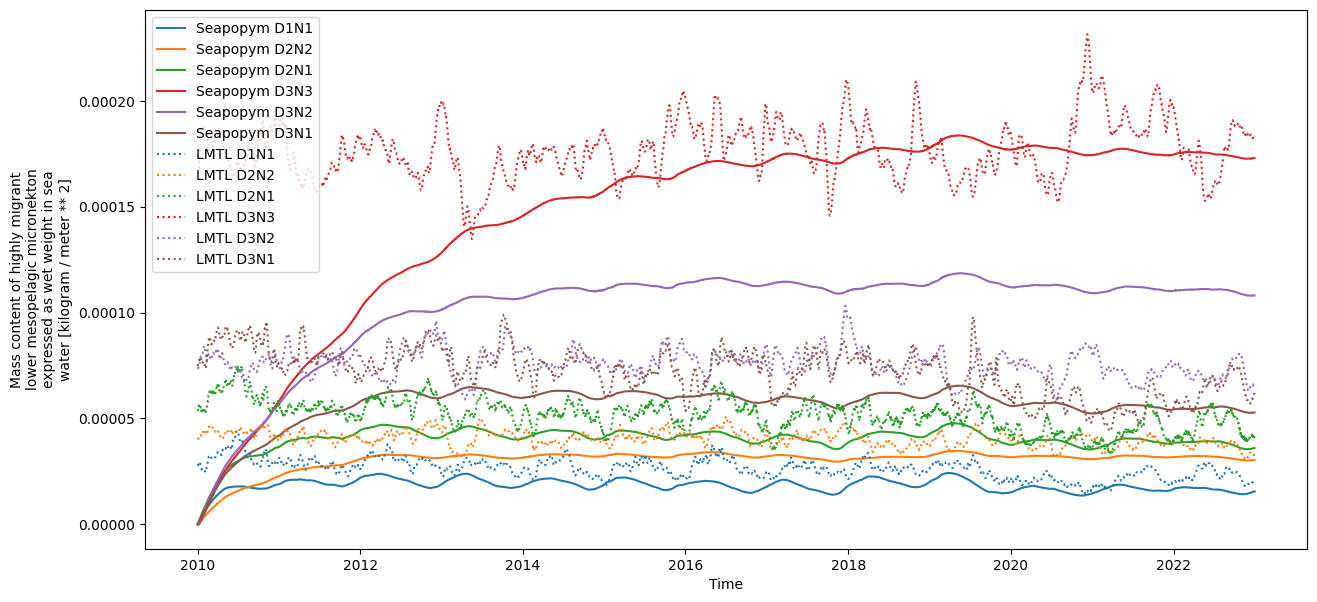

In [10]:
plt.figure(figsize=(15, 7))

color = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
lmtl_fg = ["mnkc_epi", "mnkc_umeso", "mnkc_mumeso", "mnkc_lmeso", "mnkc_mlmeso", "mnkc_hmlmeso"]
seapopym_fg = [
    "epipelagic",
    "upper_mesopelagic",
    "migrant_upper_mesopelagic",
    "lower_mesopelagic",
    "migrant_lower_mesopelagic",
    "highly_migrant_lower_mesopelagic",
]
names = ["D1N1", "D2N2", "D2N1", "D3N3", "D3N2", "D3N1"]

for i, name in enumerate(seapopym_fg):
    data = micronekton_model.state.biomass.sel(functional_group=i).cf.mean(("X", "Y"))
    data.cf.plot.line(x="time", hue="functional_group", label=f"Seapopym {names[i]}", color=color[i])
plt.legend([i.data for i in micronekton_model.state.name])

for i, name in enumerate(lmtl_fg):
    lmtl_mnk[name].plot.line(":", x="time", label=f"LMTL {names[i]}", color=color[i])
plt.legend()
plt.show()

---

## Try again with initial conditions


In [11]:
initial_conditions = micronekton_model.export_initial_conditions().load()
initial_conditions

<xarray.Dataset> Size: 553kB
Dimensions:                       (functional_group: 6, latitude: 24,
                                   longitude: 24, cohort: 19)
Coordinates:
  * functional_group              (functional_group) int64 48B 0 1 2 3 4 5
  * latitude                      (latitude) float32 96B 22.08 22.17 ... 24.0
  * longitude                     (longitude) float32 96B -159.0 ... -157.1
    time                          datetime64[ns] 8B 2022-12-31
  * cohort                        (cohort) int64 152B 0 1 2 3 4 ... 15 16 17 18
Data variables:
    initial_condition_production  (functional_group, latitude, longitude, cohort) float64 525kB ...
    initial_condition_biomass     (functional_group, latitude, longitude) float64 28kB ...

In [12]:
p_param = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=0.08333),
    primary_production=ForcingUnit(forcing=bio["npp"], resolution=0.08333),
    initial_condition_biomass=ForcingUnit(forcing=initial_conditions["initial_condition_biomass"], resolution=0.08333),
    initial_condition_production=ForcingUnit(
        forcing=initial_conditions["initial_condition_production"], resolution=0.08333
    ),
)
parameters = NoTransportParameters(
    functional_groups_parameters=f_groups, forcing_parameters=p_param, environment_parameters=environment_parameters
)
micronekton_model_with_initial_condition = NoTransportModel(configuration=NoTransportConfiguration(parameters))
micronekton_model_with_initial_condition.state

2024-04-09 16:23:17,065 :: Seapodym ::  WARNING ::
|	npp unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



<xarray.Dataset> Size: 44MB
Dimensions:                       (functional_group: 6, depth: 3, latitude: 24,
                                   longitude: 24, time: 4748, cohort: 19)
Coordinates:
  * functional_group              (functional_group) int64 48B 0 1 2 3 4 5
  * depth                         (depth) float32 12B 1.0 2.0 3.0
  * latitude                      (latitude) float32 96B 22.08 22.17 ... 24.0
  * longitude                     (longitude) float32 96B -159.0 ... -157.1
  * time                          (time) datetime64[ns] 38kB 2010-01-01 ... 2...
  * cohort                        (cohort) int64 152B 0 1 2 3 4 ... 15 16 17 18
Data variables: (12/19)
    name                          (functional_group) <U32 768B 'epipelagic' ....
    energy_transfert              (functional_group) float64 48B 0.000714 ......
    inv_lambda_max                (functional_group) float64 48B 2.109e+03 .....
    inv_lambda_rate               (functional_group) float64 48B 0.125 ... 0.125
    temperature_recruitment_max   (functional_group) float64 48B 527.0 ... 527.0
    temperature_recruitment_rate  (functional_group) float64 48B -0.125 ... -...
    ...                            ...
    resolution_latitude           float64 8B 0.08333
    resolution_longitude          float64 8B 0.08333
    timesteps_number              (functional_group, cohort) float64 912B 30....
    min_timestep                  (functional_group, cohort) float64 912B 1.0...
    max_timestep                  (functional_group, cohort) float64 912B 30....
    mean_timestep                 (functional_group, cohort) float64 912B 15....

In [13]:
micronekton_model_with_initial_condition.state

<xarray.Dataset> Size: 44MB
Dimensions:                       (functional_group: 6, depth: 3, latitude: 24,
                                   longitude: 24, time: 4748, cohort: 19)
Coordinates:
  * functional_group              (functional_group) int64 48B 0 1 2 3 4 5
  * depth                         (depth) float32 12B 1.0 2.0 3.0
  * latitude                      (latitude) float32 96B 22.08 22.17 ... 24.0
  * longitude                     (longitude) float32 96B -159.0 ... -157.1
  * time                          (time) datetime64[ns] 38kB 2010-01-01 ... 2...
  * cohort                        (cohort) int64 152B 0 1 2 3 4 ... 15 16 17 18
Data variables: (12/19)
    name                          (functional_group) <U32 768B 'epipelagic' ....
    energy_transfert              (functional_group) float64 48B 0.000714 ......
    inv_lambda_max                (functional_group) float64 48B 2.109e+03 .....
    inv_lambda_rate               (functional_group) float64 48B 0.125 ... 0.125
    temperature_recruitment_max   (functional_group) float64 48B 527.0 ... 527.0
    temperature_recruitment_rate  (functional_group) float64 48B -0.125 ... -...
    ...                            ...
    resolution_latitude           float64 8B 0.08333
    resolution_longitude          float64 8B 0.08333
    timesteps_number              (functional_group, cohort) float64 912B 30....
    min_timestep                  (functional_group, cohort) float64 912B 1.0...
    max_timestep                  (functional_group, cohort) float64 912B 30....
    mean_timestep                 (functional_group, cohort) float64 912B 15....

## Run the model


In [14]:
micronekton_model_with_initial_condition.run()

2024-04-09 16:23:17,190 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-04-09 16:23:17,194 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-04-09 16:23:17,209 :: Seapodym ::  DEBUG ::
|	Direct computation for _wrapper_mesh_day_lengths.

2024-04-09 16:23:17,365 :: Seapodym ::  DEBUG ::
|	Direct computation for _average_temperature.

2024-04-09 16:23:17,577 :: Seapodym ::  DEBUG ::
|	Direct computation for _apply_coefficient_to_primary_production_helper.

2024-04-09 16:23:17,616 :: Seapodym ::  DEBUG ::
|	Direct computation for _min_temperature_by_cohort_helper.

2024-04-09 16:23:17,617 :: Seapodym ::  DEBUG ::
|	Direct computation for _mask_temperature_helper.

2024-04-09 16:23:17,889 :: Seapodym ::  DEBUG ::
|	Direct computation for _cell_area_helper.

2024-04-09 16:23:17,913 :: Seapodym ::  DEBUG ::
|	Direct computation for _mortality_field_helper.

2024-04-09 16:23:18,116 :: Seapodym ::  DEBUG ::
|	Direct computation for _productio

In [15]:
micronekton_model_with_initial_condition.state.load()

<xarray.Dataset> Size: 6GB
Dimensions:                       (functional_group: 6, depth: 3, latitude: 24,
                                   longitude: 24, time: 4748, cohort: 19)
Coordinates:
  * functional_group              (functional_group) int64 48B 0 1 2 3 4 5
  * depth                         (depth) float32 12B 1.0 2.0 3.0
  * latitude                      (latitude) float32 96B 22.08 22.17 ... 24.0
  * longitude                     (longitude) float32 96B -159.0 ... -157.1
  * time                          (time) datetime64[ns] 38kB 2010-01-01 ... 2...
  * cohort                        (cohort) int64 152B 0 1 2 3 4 ... 15 16 17 18
Data variables: (12/31)
    name                          (functional_group) <U32 768B 'epipelagic' ....
    energy_transfert              (functional_group) float64 48B 0.000714 ......
    inv_lambda_max                (functional_group) float64 48B 2.109e+03 .....
    inv_lambda_rate               (functional_group) float64 48B 0.125 ... 0.125
    temperature_recruitment_max   (functional_group) float64 48B 527.0 ... 527.0
    temperature_recruitment_rate  (functional_group) float64 48B -0.125 ... -...
    ...                            ...
    mask_temperature              (functional_group, time, latitude, longitude, cohort) bool 312MB ...
    cell_area                     (latitude, longitude) float64 5kB 7.956e+07...
    mortality_field               (functional_group, time, latitude, longitude) float64 131MB ...
    recruited                     (functional_group, time, latitude, longitude, cohort) float64 2GB ...
    preproduction                 (functional_group, time, latitude, longitude, cohort) float64 2GB ...
    biomass                       (functional_group, time, latitude, longitude) float64 131MB ...

## Plotting the results


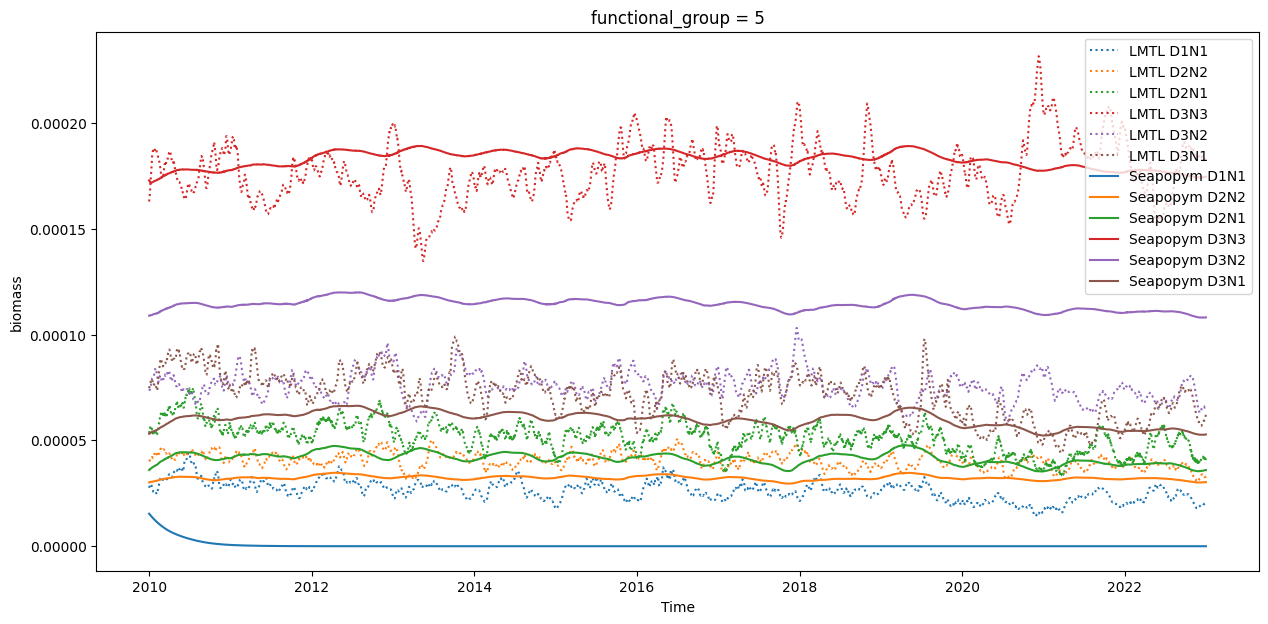

In [16]:
plt.figure(figsize=(15, 7))

for i, name in enumerate(lmtl_fg):
    lmtl_mnk[name].plot.line(":", x="time", label=f"LMTL {names[i]}", color=color[i])

for i, name in enumerate(seapopym_fg):
    data = micronekton_model_with_initial_condition.state.biomass.sel(functional_group=i).cf.mean(("X", "Y"))
    data.cf.plot.line(x="time", hue="functional_group", label=f"Seapopym {names[i]}", color=color[i])
plt.legend([i.data for i in micronekton_model.state.name])

plt.legend()
plt.show()